In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import scipy
import scipy.stats
import matplotlib
from scipy import interpolate
import os
import itertools
from textwrap import wrap
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.font_manager as fm
import scipy.stats
import networkx as nx
from sklearn.decomposition import PCA
from sklearn import metrics
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import radius_neighbors_graph
import matplotlib.patches as mpatches
import sklearn.neighbors
from scipy.spatial import distance
from skimage.filters import unsharp_mask
from skimage.color import rgb2gray
from mpl_toolkits.axes_grid1 import ImageGrid
from collections import Counter
import skimage
from Bio import SeqIO
from Bio.KEGG import REST
from Bio.KEGG.KGML import KGML_parser
import io
import numpy as np
import gget
import matplotlib.pyplot as plt
from skimage import data, segmentation, feature, future
from sklearn.ensemble import RandomForestClassifier
from functools import partial
import sys

from mpl_toolkits.mplot3d import Axes3D
sys.path.append("../")
import utils as ut
from importlib import reload
reload(ut)


<module 'utils' from '/home/cstansbu/git_repositories/spatial_transcriptomics/clustering/spatial/../utils.py'>

In [2]:
# upload the scale factors

keys = ['ND', 'HFD8', 'HFD14']

scales = []

for key in keys:
    path = f"/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/SPT/{key}/outs/spatial/scalefactors_json.json"
    
    tmp = pd.read_json(path, lines=True)
    tmp['key'] = key
    # tmp['lowres_spot_diameter_pixels'] = tmp['spot_diameter_fullres'] * tmp['tissue_lowres_scalef']
    # tmp['lowres_spot_diameter_units'] = tmp['lowres_spot_diameter_pixels'] * 65
    
    scales.append(tmp)
    
scales = pd.concat(scales, ignore_index=True)
print(scales)
# print(scales[['key', 'spot_diameter_fullres', 'lowres_spot_diameter_pixels']])


def getscalebar(key, length, scales=scales):
    """Length is physical units """
    lookup = scales.loc[scales['key'] == key]
    pixels = lookup['spot_diameter_fullres'].values[0]
    scaleFactor = lookup['tissue_lowres_scalef'].values[0]
    units = 65 # mircons
    
    fullResPixels = (pixels * length) / units
    lowResPixels = fullResPixels * scaleFactor
    
    return lowResPixels
    
getscalebar('ND', length=100)

   spot_diameter_fullres  tissue_hires_scalef  fiducial_diameter_fullres   
0             257.195160             0.050684                 415.469120  \
1             257.368127             0.051089                 415.748513   
2             257.404844             0.049124                 415.807825   

   tissue_lowres_scalef    key  
0              0.015205     ND  
1              0.015327   HFD8  
2              0.014737  HFD14  


6.016495945974647

In [3]:
imDir = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/images/lowres/"


lowres = {}

for f in os.listdir(imDir):
    if f.endswith("png"):
        fullpath = f"{imDir}{f}"
        img = skimage.io.imread(fullpath, as_gray=True)
        key = f.replace(".png", "")
        print(key, img.shape)
        lowres[key] = img

print('done')

HFD14 (2000, 1628)
ND (2000, 1681)
HFD8 (2000, 1692)
done


In [4]:
fPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/LR/LewisLabUSCS/Mouse/Mouse-2020-Baccin-LR-pairs.xlsx"

lr = pd.read_excel(fPath, engine="openpyxl")
print(lr.shape)

lr['ligand'] = lr['Ligand.Mouse'].str.upper()
lr['receptor'] = lr['Receptor.Mouse'].str.upper()
lr.head()

(2000, 8)


,Pair.Name,Ligand.Mouse,Receptor.Mouse,Source,ManualAnnotation,Ligand.CC,Ligand.GO,Reference (PMID / KEGG),ligand,receptor
0,A2m-Lrp1,A2m,Lrp1,Ramilowski,Correct,Secreted,Other,"1702392,10652313, 12194978",A2M,LRP1
1,Adgre5-Cd55,Adgre5,Cd55,Baccin,Correct,Membrane,Other,23447688,ADGRE5,CD55
2,Adipoq-Adipor1,Adipoq,Adipor1,Ramilowski,Correct,Secreted,Other,12802337,ADIPOQ,ADIPOR1
3,Adipoq-Adipor2,Adipoq,Adipor2,Ramilowski,Correct,Secreted,Other,"12802337, 12802330",ADIPOQ,ADIPOR2
4,Adm-Calcrl&Ramp2,Adm,Calcrl&Ramp2,Baccin,Correct,Secreted,Other,10342881,ADM,CALCRL&RAMP2


In [5]:
cardOutDir = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDOuputs/"

dfList = []

for f in os.listdir(cardOutDir):
    if 'global' in f:
        fullPath = f"{cardOutDir}{f}"
        key = f.split("_")[0]
        df = pd.read_csv(fullPath)
        df = df.rename(columns={'Unnamed: 0' : 'spotId'})
        df['key'] = key
        dfList.append(df)

df = pd.concat(dfList, ignore_index=True)
print(f"{df.shape=}")
print(df['key'].value_counts())
print()
df.head()

df.shape=(7418, 13)
key
HFD8     3391
ND       2034
HFD14    1993
Name: count, dtype: int64



,spotId,B cells,Mac1,Mac3,Monocytes,T cells,NK cells,Stromal cells,Dendritic cells,Mac4,Mac2,Mac5,key
0,AAACAAGTATCTCCCA.1_ND,0.018691,0.009410,0.010737,0.070782,0.040298,0.077389,0.645332,0.015281,0.045516,0.039354,0.027211,ND
1,AAACAGCTTTCAGAAG.1_ND,0.008378,0.005700,0.038038,0.089932,0.048618,0.103983,0.575021,0.046758,0.020027,0.035451,0.028094,ND
2,AAACAGGGTCTATATT.1_ND,0.024325,0.010761,0.024323,0.117606,0.072993,0.121093,0.478383,0.026608,0.042051,0.048258,0.033598,ND
3,AAACATTTCCCGGATT.1_ND,0.023002,0.014704,0.044181,0.087019,0.053537,0.083922,0.465958,0.053223,0.087758,0.037452,0.049242,ND
4,AAACCCGAACGAAATC.1_ND,0.021954,0.003784,0.001240,0.038020,0.026386,0.061364,0.775170,0.003725,0.023106,0.025914,0.019336,ND


In [6]:
sptDir =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDInputs/"

spt = {}

for f in os.listdir(sptDir):
    if "spt" in f and "global" in f:
        fullPath = f"{sptDir}{f}"
        key = f.split("_")[0]
        sdf = pd.read_csv(fullPath)
        sdf = sdf.rename(columns={'Unnamed: 0' : 'gene'})
        sdf = sdf.set_index('gene')
        sdf = sdf.T
        sdf.index = sdf.index.str.replace("-", ".")
        sdf = ut.normalize(sdf, 1e6)
        spt[key] = sdf
        print(f, sdf.shape)
    
print('done')

HFD8_global_spt.csv (3394, 31053)
ND_global_spt.csv (2036, 31053)
HFD14_global_spt.csv (1994, 31053)
done


In [7]:
coordDir = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDInputs/"

dfList = []

for f in os.listdir(coordDir):
    if "coord" in f and "global" in f:
        fullPath = f"{coordDir}{f}"
        key = f.split("_")[0]
        cdf = pd.read_csv(fullPath)
        cdf = cdf.rename(columns={'Unnamed: 0' : 'spotId'})
        cdf['key'] = key
        dfList.append(cdf)

cdf = pd.concat(dfList, ignore_index=True)
print(f"{cdf.shape=}")
print(cdf['key'].value_counts())
print()
cdf.head()

cdf.shape=(7424, 4)
key
HFD8     3394
ND       2036
HFD14    1994
Name: count, dtype: int64



,spotId,x,y,key
0,AAACAAGTATCTCCCA.1_HFD8,1244.795278,1189.669724,HFD8
1,AAACACCAATAACTGC.1_HFD8,405.548324,1349.579809,HFD8
2,AAACAGCTTTCAGAAG.1_HFD8,303.880251,1068.178931,HFD8
3,AAACAGGGTCTATATT.1_HFD8,344.496391,1138.478061,HFD8
4,AAACAGTGTTCCTGGG.1_HFD8,648.734268,1595.524585,HFD8


In [8]:
"""Merge CARD predictions with spatial coordinates"""
df = pd.merge(cdf, df,
              how='left', 
              left_on=['spotId', 'key'],
              right_on=['spotId', 'key'])

df = df.fillna(0)
df = df.drop_duplicates() # very important!
print(df['key'].value_counts())
df.head()

key
HFD8     3394
ND       2036
HFD14    1994
Name: count, dtype: int64


,spotId,x,y,key,B cells,Mac1,Mac3,Monocytes,T cells,NK cells,Stromal cells,Dendritic cells,Mac4,Mac2,Mac5
0,AAACAAGTATCTCCCA.1_HFD8,1244.795278,1189.669724,HFD8,0.077635,0.022735,0.104811,0.111453,0.125867,0.195064,0.059765,0.111978,0.082445,0.066571,0.041676
1,AAACACCAATAACTGC.1_HFD8,405.548324,1349.579809,HFD8,0.076987,0.041831,0.047343,0.139484,0.082711,0.093085,0.148247,0.071763,0.058744,0.142045,0.097760
2,AAACAGCTTTCAGAAG.1_HFD8,303.880251,1068.178931,HFD8,0.079216,0.043327,0.075868,0.086821,0.086695,0.097747,0.186142,0.090520,0.069670,0.094246,0.089748
3,AAACAGGGTCTATATT.1_HFD8,344.496391,1138.478061,HFD8,0.037682,0.029618,0.093281,0.109521,0.052151,0.061401,0.201332,0.094533,0.143671,0.088173,0.088637
4,AAACAGTGTTCCTGGG.1_HFD8,648.734268,1595.524585,HFD8,0.092691,0.001555,0.002745,0.075636,0.054631,0.052849,0.112912,0.008552,0.258918,0.056771,0.282740


In [16]:
def closest_node(node, nodes, metric):
    closest_index = distance.cdist([node], nodes, metric=metric).argmin()
    return closest_index

def getSubGraph(kdf, n, metric='minkowski'):
    """A function to generate a graph of size n x n
    around point (x, y) """
    
    nodes = kdf[['x', 'y']]

    x = kdf['x'].mean()
    y = kdf['y'].mean()
    
    centerInd = closest_node([x, y], nodes, metric)
    
      
    # get the n points around that node
    nbrs = NearestNeighbors(n_neighbors=n,  
                            metric=metric, 
                            algorithm='ball_tree').fit(nodes)
    distances, indices = nbrs.kneighbors(nodes)
    
    # create the subgraph
    windowIndices = indices[centerInd]
    mask = kdf.index.isin(windowIndices)
    
    center = kdf[mask].reset_index(drop=True)
    dists = sklearn.metrics.pairwise_distances(center[['x', 'y']], metric=metric)
    
    X = dists
    
    # create the graph
    nodeMapper = dict(zip(center.index, center['spotId']))
    G = nx.from_numpy_array(X)
    G = nx.relabel_nodes(G, nodeMapper)
    
    # set positions
    pos = {}
    for idx, row in center.iterrows():
        pos[row['spotId']] = np.array(row[['x', 'y']])
    
    G.pos = pos
    return G
    
    
def getFullGraph(kdf, metric='minkowski'):
    """A function to generate a graph of size n x n
    around point (x, y) """
    
    nodes = kdf[['x', 'y']]

    dists = sklearn.metrics.pairwise_distances(nodes, metric=metric)
    np.fill_diagonal(dists, 0) # no self loops!
    X = dists
    
    # create the graph
    nodeMapper = dict(zip(kdf.index, kdf['spotId']))
    G = nx.from_numpy_array(X)
    G = nx.relabel_nodes(G, nodeMapper)
    
    # set positions
    pos = {}
    for idx, row in kdf.iterrows():
        pos[row['spotId']] = np.array(row[['x', 'y']])
    
    G.pos = pos
    return G
    
    
def getKnn(kdf, k=6, metric='minkowski'):
    """A function to generate a knn graph """
    
    nodes = kdf[['x', 'y']]
      
    # get the n points around that node
    nbrs = NearestNeighbors(n_neighbors=k+1,  
                            metric=metric, 
                            algorithm='ball_tree').fit(nodes)
    distances, indices = nbrs.kneighbors(nodes)
    return indices


def knnInd2Id(kdf, knnInd):
    """Translate neighbors to spotIds """
    
    transId = {}
    
    for i, row in kdf.iterrows():
        spotId = row['spotId']
        nbrhs = kdf.iloc[knnInd[i]]['spotId'].values
        transId[spotId] = nbrhs
    return transId
    
    

def blur(sdf, transId):
    """A function to blur all columns using their neighbors.
    Expects spotIds as index """
    
    results  = []
    
    for spotId, nbhs in transId.items():
        
        # make sure the spot is present
        if spotId in sdf.index:
            nbhs = [x for x in nbhs if x in sdf.index]
            
            t = sdf.loc[nbhs].mean().to_dict()
            t['spotId'] = spotId
            results.append(t)
        
    results = pd.DataFrame(results)
    results = results.set_index('spotId')
    return results


def getCentralities(G):
    """ function to compute centralities """
    cf = pd.DataFrame({'spotId' : G.nodes()})
    cf['degree_centrality'] = cf['spotId'].map(nx.degree_centrality(G))
    cf['betweenness_centrality'] = cf['spotId'].map(nx.betweenness_centrality(G))
    # cf['closeness_centrality'] = cf['spotId'].map(nx.closeness_centrality(G))
    # cf['harmonic_centrality'] = cf['spotId'].map(nx.harmonic_centrality(G))
    cf['eigenvector_centrality'] = cf['spotId'].map(nx.eigenvector_centrality(G, tol=0.001))
    return cf


def prune(G, weight, threshold, min_components):
    """A function to prune disconnected components """
    H = nx.Graph(((u, v, e) for u,v,e in G.edges(data=True) if e[weight] < threshold))
    H.pos = G.pos
    
    for component in list(nx.connected_components(H)):
        if len(component) < min_components:
            for node in component:
                H.remove_node(node)
    return H



    
def removeDisconnectedNodes(G, radius=25, min_edges=3):
    """A function to remove spots that are not nearby
    other spots """
    H = G.copy()
    H.pos = G.pos
    
    H.remove_edges_from([(n1, n2) for n1, n2, w in H.edges(data="weight") if w > radius])
    degree = pd.DataFrame(nx.degree(H), columns=['node', 'degree'])
    
    mask = (degree['degree'] > min_edges)
    dropNodes = degree[~mask]
    
    # drop the nodes
    H.remove_nodes_from(dropNodes['node'].to_list())
    
    return H

In [18]:
keys = ['ND', 'HFD8', 'HFD14']
graph = {}
n = 100 # size of the graph


"""
NOTE: here we remove edges that are greater distance than the nearest neighbor
""" 
    
for i, key in enumerate(keys):
    kdf = df[df['key'] == key].reset_index(drop=True)
    G = getSubGraph(kdf, n)
    graph[key] = G
    
print('done')

done


In [19]:
cTypes = [
    'Mac1',
    'Mac2',
    'Mac3',
    'Mac4',
    'Mac5',
]

In [20]:
"""Build the graph"""

allGraphs = {}
radius = 25

for i, key in enumerate(keys):
    
    kdf = df[df['key'] == key].reset_index(drop=True)
    G = graph[key]
    
    normedCols = {}
    for ctype in cTypes:
        newCol = f"{ctype} norm"
        normedCols[newCol] = ctype
        kdf[newCol] = kdf[ctype] / kdf[ctype].max()
        
    node_attr = kdf.set_index('spotId').to_dict('index')
    nx.set_node_attributes(G, node_attr)    
    
    edgelists = {}
    for u,v,e in G.edges(data=True):
        if e['weight'] < radius:
            
            for norm, ctype in normedCols.items():
                x1 = G.nodes[u][norm]
                x2 = G.nodes[v][norm]
                
                w = scipy.stats.hmean([x1, x2])
                edge = (u,v, w)
                
                if ctype in edgelists.keys():
                    edgelists[ctype].append(edge)
                else:
                    edgelists[ctype] = [edge]
                
    """ create the subgraph """
    H = nx.Graph()
    H.add_nodes_from(G.nodes())
    
    for ctype in cTypes:
        edges = edgelists[ctype]
        H.add_weighted_edges_from(edges, weight=ctype)
    H.pos = G.pos
    nx.set_node_attributes(H, node_attr)  
    allGraphs[key] = H
    
print('done')

done


In [ ]:
# break

In [64]:
ut.MACCOLORS

['#9835e4', '#e48035', '#8e0152', '#9acd61', '#276419']

img.shape=(2000, 1628)


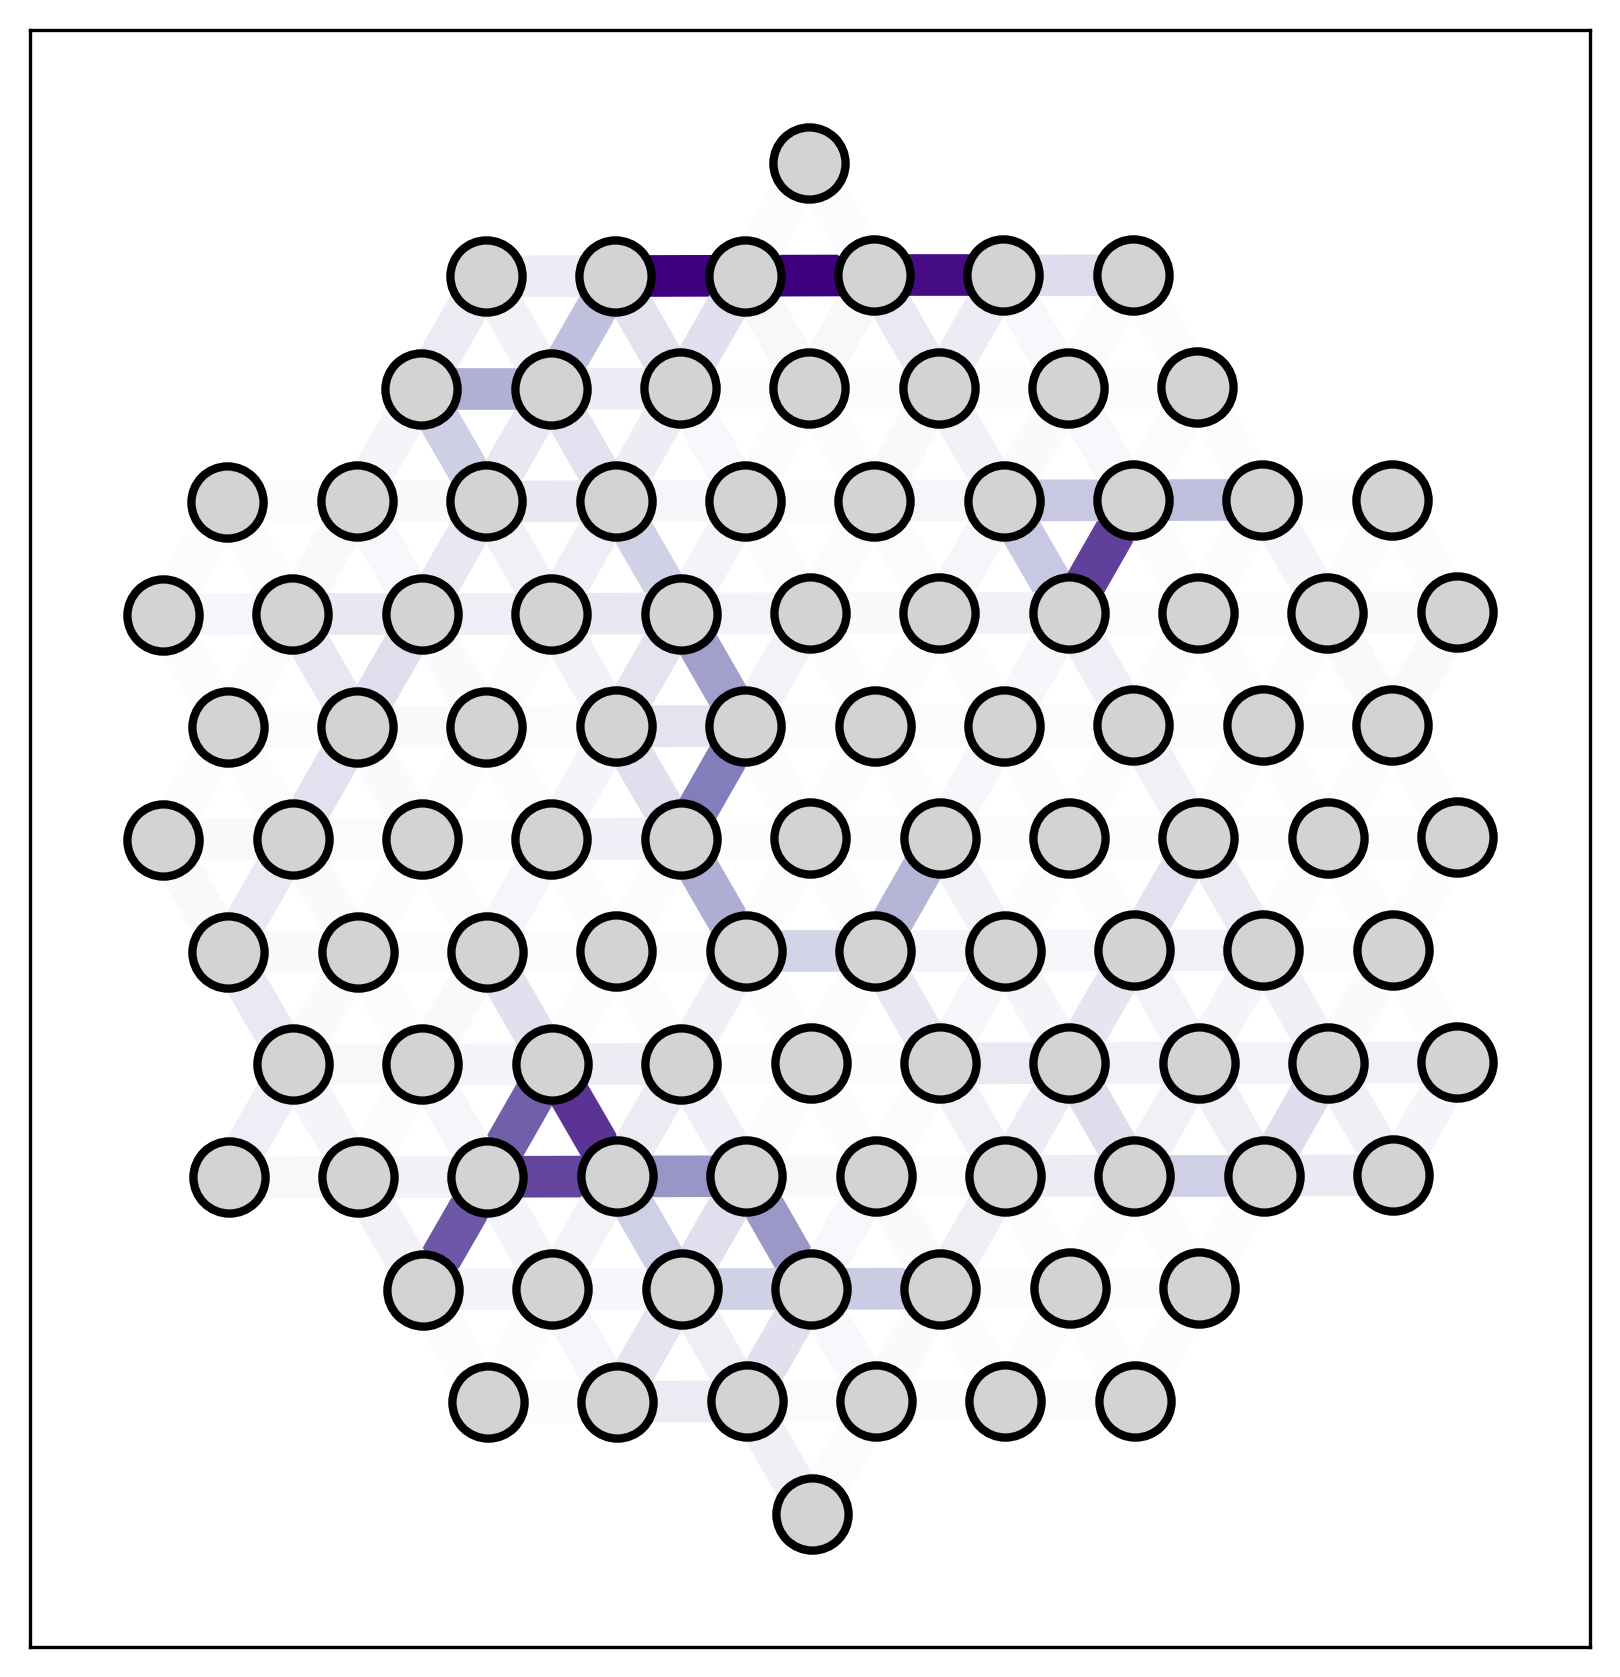

In [124]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 7, 7

# fig, axs = plt.subplots(1, 1)

key = 'HFD14'
window = 20
edgeThreshold = 0.01



G = allGraphs[key]
img = lowres[key]
print(f"{img.shape=}")

# get the window
pos = np.asarray([v for k, v in G.pos.items()])
xmax = pos[:, 0].max() + window
xmin = pos[:, 0].min() - window
ymax = pos[:, 1].max() + window
ymin = pos[:, 1].min() - window


fig, ax = plt.subplots()

# ax.imshow(img, cmap='binary_r', alpha=0.5)
ax.set_ylim([ymin, ymax])
ax.set_xlim([xmin, xmax])

nx.draw_networkx_nodes(G,
                       pos=G.pos,
                       node_size=300,
                       node_color='lightgrey',
                       edgecolors='k',
                       linewidths=2,
                       ax=ax)
        
eweights = np.array([e['Mac1'] for node1, node2, e in G.edges(data=True)])
eweights = np.where(eweights > edgeThreshold, eweights, 0) # threshold

colors = ["#276419", "w"]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)


nx.draw_networkx_edges(G,
                       pos=G.pos,
                       width=10,
                       edge_color=eweights,
                       # edge_cmap=plt.cm.get_cmap('Greens'), 
                       edge_cmap=plt.cm.get_cmap('Purples'), 
                       edge_vmin=0.01, 
                       edge_vmax=0.15,
                       ax=ax)     

# ax.set_title(key)
ax.set_aspect('equal')
ax.invert_yaxis()
